In [ ]:
#Making a fraud detection dataset
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from io import StringIO

# সীড সেট করুন রিপ্রডিউসিবিলিটির জন্য
np.random.seed(42)
random.seed(42)

# ডেটাসেট সাইজ
n_rows = 800

# ফ্রড রেশিও (ইমব্যালান্সড)
fraud_ratio = 0.12
n_fraud = int(n_rows * fraud_ratio)
n_non_fraud = n_rows - n_fraud

# শহরের তালিকা (কিছুতে স্পেলিং ভুল থাকবে)
cities = ['Dhaka', 'Chittagong', 'Khulna', 'Rajshahi', 'Sylhet', 'Barisal', 'Rangpur', 
          'Cumilla', 'Narayanganj', 'Gazipur', 'Daka', 'Chittagong', 'Khulnaa', 'Rajshai']

# ট্রানজ্যাকশন টাইপ
transaction_types = ['Online Purchase', 'Cash Withdrawal', 'Money Transfer', 'Bill Payment', 'POS']

# মার্চেন্ট ক্যাটেগরি
merchant_categories = ['Electronics', 'Retail', 'Travel', 'Food', 'Utilities', 
                       'Financial Services', 'ATM', 'Healthcare', 'Entertainment']

# ডিভাইস টাইপ
device_types = ['Mobile', 'Desktop', 'Tablet', None]

# ফাংশন ডেফিনিশন
def generate_customer_id():
    return random.randint(1000, 9999)

def generate_age(is_fraud):
    if random.random() < 0.05:  # 5% মিসিং
        return None
    if is_fraud and random.random() < 0.1:  # ফ্রড কেসে আউটলায়ার বেশি
        return random.choice([5, 150, 200, -10])
    return random.randint(18, 70)

def generate_city():
    if random.random() < 0.03:  # 3% মিসিং
        return None
    city = random.choice(cities)
    # স্পেলিং ভুল যোগ
    if random.random() < 0.05:
        if city == 'Dhaka':
            return random.choice(['Daka', 'Dhaka', 'Dacca'])
        elif city == 'Chittagong':
            return random.choice(['Chittagong', 'Chattogram', 'Chitagong'])
    return city

def generate_account_age(is_fraud):
    if is_fraud:
        return random.choices([random.randint(1, 3), random.randint(4, 12), random.randint(13, 60)], 
                              weights=[0.6, 0.3, 0.1])[0]
    return random.randint(1, 120)

def generate_balance(is_fraud):
    if random.random() < 0.02:  # 2% মিসিং
        return None
    if is_fraud:
        return random.randint(5000, 100000)
    return random.randint(20000, 1000000)

def generate_transaction_amount(is_fraud):
    if is_fraud:
        # ফ্রড কেসে বড় অংক বেশি
        return random.choices(
            [random.randint(50000, 200000), random.randint(20000, 50000), random.randint(1000, 20000)],
            weights=[0.6, 0.3, 0.1]
        )[0] + random.random() * 100
    return random.randint(1000, 100000) + random.random() * 100

def generate_transaction_type(is_fraud):
    if is_fraud:
        # ফ্রড কেসে কিছু টাইপ বেশি কমন
        return random.choices(['Cash Withdrawal', 'Money Transfer', 'Online Purchase', 'Bill Payment'],
                              weights=[0.4, 0.4, 0.15, 0.05])[0]
    return random.choice(transaction_types)

def generate_transaction_time(is_fraud):
    base_date = datetime(2024, 1, 1)
    days_offset = random.randint(0, 365)
    hours = random.randint(0, 23)
    minutes = random.randint(0, 59)
    
    if is_fraud:
        # ফ্রড ট্রানজ্যাকশন রাতের বেলা বেশি
        hours = random.choices(
            list(range(24)),
            weights=[0.02]*6 + [0.03]*6 + [0.05]*6 + [0.1]*6  # রাতে বেশি ওজন
        )[0]
    
    transaction_time = base_date + timedelta(days=days_offset, hours=hours, minutes=minutes)
    return transaction_time.strftime('%Y-%m-%d %H:%M:%S')

def generate_merchant_category(txn_type, is_fraud):
    if txn_type == 'Cash Withdrawal':
        return 'ATM'
    elif txn_type == 'Bill Payment':
        return 'Utilities'
    elif txn_type == 'Money Transfer':
        return 'Financial Services'
    
    if is_fraud:
        return random.choices(['ATM', 'Financial Services', 'Travel', 'Electronics'],
                              weights=[0.4, 0.3, 0.2, 0.1])[0]
    return random.choice(merchant_categories)

def generate_previous_fraud_count(is_fraud):
    if is_fraud:
        return random.choices([0, 1, 2, 3, 4], weights=[0.3, 0.3, 0.2, 0.15, 0.05])[0]
    return random.choices([0, 1, 2], weights=[0.9, 0.08, 0.02])[0]

def generate_device_type(is_fraud):
    if random.random() < 0.08:  # 8% মিসিং
        return None
    if is_fraud:
        return random.choices(['Mobile', None, 'Desktop'], weights=[0.7, 0.2, 0.1])[0]
    return random.choice(device_types)

def generate_is_foreign(is_fraud):
    if is_fraud:
        return random.choices([1, 0], weights=[0.7, 0.3])[0]
    return random.choices([1, 0], weights=[0.1, 0.9])[0]

def generate_login_hours(is_fraud):
    if is_fraud:
        # ফ্রড কেসে লগইনের ঠিক আগে ট্রানজ্যাকশন
        return random.choices(
            [random.uniform(0, 1), random.uniform(1, 6), random.uniform(6, 24), random.uniform(24, 72)],
            weights=[0.6, 0.3, 0.08, 0.02]
        )[0]
    return random.uniform(0, 72)

# ডেটা জেনারেট করছি
data = []
customer_ids = set()

# প্রথমে ফ্রড কেস জেনারেট করি
for i in range(n_fraud):
    customer_id = generate_customer_id()
    while customer_id in customer_ids:
        customer_id = generate_customer_id()
    customer_ids.add(customer_id)
    
    is_fraud = 1
    
    age = generate_age(is_fraud)
    city = generate_city()
    account_age = generate_account_age(is_fraud)
    balance = generate_balance(is_fraud)
    txn_amount = generate_transaction_amount(is_fraud)
    txn_type = generate_transaction_type(is_fraud)
    txn_time = generate_transaction_time(is_fraud)
    merchant_cat = generate_merchant_category(txn_type, is_fraud)
    prev_fraud = generate_previous_fraud_count(is_fraud)
    device = generate_device_type(is_fraud)
    is_foreign = generate_is_foreign(is_fraud)
    login_hours = generate_login_hours(is_fraud)
    
    data.append([
        i + 1,  # transaction_id
        customer_id,
        age,
        city,
        account_age,
        balance,
        round(txn_amount, 2),
        txn_type,
        txn_time,
        merchant_cat,
        prev_fraud,
        device,
        is_foreign,
        round(login_hours, 2),
        is_fraud
    ])

# এখন নন-ফ্রড কেস জেনারেট করি
for i in range(n_non_fraud):
    customer_id = generate_customer_id()
    while customer_id in customer_ids and len(customer_ids) < 500:
        customer_id = generate_customer_id()
    customer_ids.add(customer_id)
    
    is_fraud = 0
    
    age = generate_age(is_fraud)
    city = generate_city()
    account_age = generate_account_age(is_fraud)
    balance = generate_balance(is_fraud)
    txn_amount = generate_transaction_amount(is_fraud)
    txn_type = generate_transaction_type(is_fraud)
    txn_time = generate_transaction_time(is_fraud)
    merchant_cat = generate_merchant_category(txn_type, is_fraud)
    prev_fraud = generate_previous_fraud_count(is_fraud)
    device = generate_device_type(is_fraud)
    is_foreign = generate_is_foreign(is_fraud)
    login_hours = generate_login_hours(is_fraud)
    
    data.append([
        n_fraud + i + 1,  # transaction_id
        customer_id,
        age,
        city,
        account_age,
        balance,
        round(txn_amount, 2),
        txn_type,
        txn_time,
        merchant_cat,
        prev_fraud,
        device,
        is_foreign,
        round(login_hours, 2),
        is_fraud
    ])

# ডেটাকে শাফল করি
random.shuffle(data)

# DataFrame তৈরি করি
columns = [
    'transaction_id', 'customer_id', 'age', 'city', 'account_age_months',
    'avg_monthly_balance', 'transaction_amount', 'transaction_type',
    'transaction_time', 'merchant_category', 'previous_fraud_count',
    'device_type', 'is_foreign_transaction', 'login_hours_before_transaction',
    'is_fraud'
]

df = pd.DataFrame(data, columns=columns)

# CSV ফাইল হিসেবে সেভ করি
df.to_csv('fraud_detection_dataset.csv', index=False)

print("✅ ডেটাসেট তৈরি হয়েছে: fraud_detection_dataset.csv")
print(f"মোট রোও: {len(df)}")
print(f"ফ্রড কেস: {df['is_fraud'].sum()} ({df['is_fraud'].mean()*100:.1f}%)")
print(f"নন-ফ্রড কেস: {len(df) - df['is_fraud'].sum()}")

# ডেটা কোয়ালিটি চেক
print("\nডেটা কোয়ালিটি সারাংশ:")
print(df.isnull().sum())

print("\nকিছু নমুনা ডেটা:")
print(df.head(10))

✅ ডেটাসেট তৈরি হয়েছে: fraud_detection_dataset.csv
মোট রোও: 800
ফ্রড কেস: 96 (12.0%)
নন-ফ্রড কেস: 704

ডেটা কোয়ালিটি সারাংশ:
transaction_id                      0
customer_id                         0
age                                46
city                               19
account_age_months                  0
avg_monthly_balance                18
transaction_amount                  0
transaction_type                    0
transaction_time                    0
merchant_category                   0
previous_fraud_count                0
device_type                       239
is_foreign_transaction              0
login_hours_before_transaction      0
is_fraud                            0
dtype: int64

কিছু নমুনা ডেটা:
   transaction_id  customer_id   age        city  account_age_months  \
0             545         4018  46.0       Dhaka                  30   
1             748         1377  35.0        Daka                 102   
2             662         2583  68.0  Chittagong           

In [14]:
#importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score, auc

In [2]:
df.head()

,transaction_id,customer_id,age,city,account_age_months,avg_monthly_balance,transaction_amount,transaction_type,transaction_time,merchant_category,previous_fraud_count,device_type,is_foreign_transaction,login_hours_before_transaction,is_fraud
0,545,4018,46.0,Dhaka,30,769259.0,35051.53,Online Purchase,2024-12-13 11:34:00,Electronics,0,Mobile,0,8.15,0
1,748,1377,35.0,Daka,102,378915.0,43217.07,POS,2024-11-11 12:53:00,Healthcare,0,Mobile,0,50.32,0
2,662,2583,68.0,Chittagong,41,886431.0,80201.78,Money Transfer,2024-12-25 20:35:00,Financial Services,0,Tablet,0,3.83,0
3,724,3612,54.0,Rajshai,106,105714.0,56004.07,POS,2024-10-05 01:33:00,Retail,0,Desktop,0,49.25,0
4,526,8925,48.0,Khulna,119,710912.0,69894.92,Money Transfer,2024-10-28 18:22:00,Financial Services,0,Mobile,1,61.35,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   transaction_id                  800 non-null    int64  
 1   customer_id                     800 non-null    int64  
 2   age                             754 non-null    float64
 3   city                            781 non-null    object 
 4   account_age_months              800 non-null    int64  
 5   avg_monthly_balance             782 non-null    float64
 6   transaction_amount              800 non-null    float64
 7   transaction_type                800 non-null    object 
 8   transaction_time                800 non-null    object 
 9   merchant_category               800 non-null    object 
 10  previous_fraud_count            800 non-null    int64  
 11  device_type                     561 non-null    object 
 12  is_foreign_transaction          800 

In [ ]:
#seeing duplicate value
df.duplicated().sum()

np.int64(0)

In [ ]:
#seeing NAN value
df.isna().sum()

transaction_id                      0
customer_id                         0
age                                46
city                               19
account_age_months                  0
avg_monthly_balance                18
transaction_amount                  0
transaction_type                    0
transaction_time                    0
merchant_category                   0
previous_fraud_count                0
device_type                       239
is_foreign_transaction              0
login_hours_before_transaction      0
is_fraud                            0
dtype: int64

In [ ]:
#counting city value
df['city'].value_counts()

city
Chittagong     103
Khulnaa         71
Rajshahi        63
Barisal         62
Sylhet          60
Khulna          57
Rangpur         57
Rajshai         54
Narayanganj     53
Daka            52
Gazipur         52
Dhaka           48
Cumilla         45
Chattogram       2
Chitagong        1
Dacca            1
Name: count, dtype: int64

In [ ]:
#counting device type value
df['device_type'].value_counts()

device_type
Mobile     210
Desktop    178
Tablet     173
Name: count, dtype: int64

In [ ]:
#filling NAN value using ffill()
df['city'] = df['city'].ffill()

In [ ]:
#filling 
df['device_type'] = df['device_type'].bfill()

In [12]:
df['device_type'].value_counts()

device_type
Mobile     283
Desktop    260
Tablet     257
Name: count, dtype: int64

In [13]:
#counting city value
df['city'].value_counts()

city
Chittagong     105
Khulnaa         71
Rajshahi        64
Barisal         64
Sylhet          61
Rangpur         59
Khulna          58
Narayanganj     57
Rajshai         56
Daka            53
Gazipur         53
Dhaka           48
Cumilla         47
Chattogram       2
Chitagong        1
Dacca            1
Name: count, dtype: int64

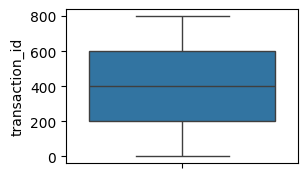

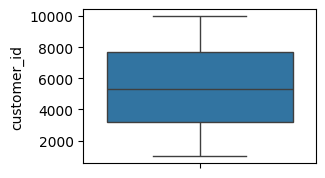

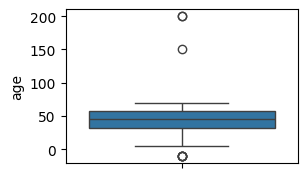

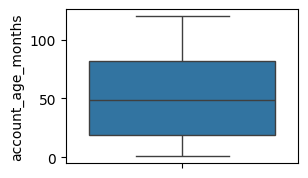

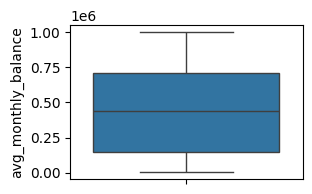

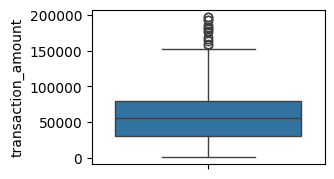

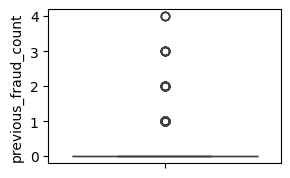

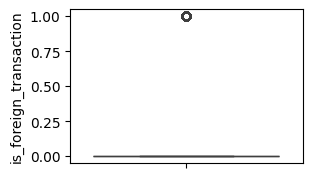

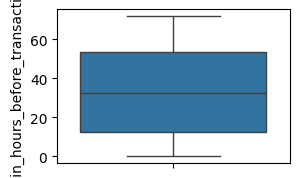

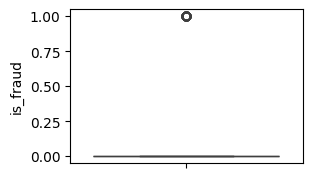

In [16]:
#seeing outlier using boxplot
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(3,2))
    sns.boxplot(df[col])
    plt.show()

In [18]:
#counting outlier
outlier_count = {}
for col1 in df.select_dtypes(include='number').columns:
    q1 = df[col1].quantile(.25)
    q3 = df[col1].quantile(.75)

    iqr = q3 - q1

    up_wh = q3 + 1.5 * iqr
    low_wh = q1 - 1.5 * iqr

    counts = (df[col1] < low_wh) | (df[col1] > up_wh)
    outlier_count[col1] = counts.sum()

outlier_df = pd.DataFrame({
    'columns': outlier_count.keys(),
    'Outlier_counts': outlier_count.values()
})
outlier_df

,columns,Outlier_counts
0,transaction_id,0
1,customer_id,0
2,age,8
3,account_age_months,0
4,avg_monthly_balance,0
5,transaction_amount,15
6,previous_fraud_count,142
7,is_foreign_transaction,151
8,login_hours_before_transaction,0
9,is_fraud,96


In [ ]:
#removing outlier using boxplot
def outlier(df, col2):
    q1 = df[col1].quantile(.25)
    q3 = df[col1].quantile(.75)

    iqr = q3 - q1

    up_wh = q3 + 1.5 * iqr
    low_wh = q1 - 1.5 * iqr
    
    return df[(df[col1] <= low_wh) & (df[col1] <= up_wh)]

In [20]:
df_clean = df.copy()

In [21]:
for col3 in df.select_dtypes(include='number').columns:
    df_clean = outlier(df_clean, col3)

In [22]:
df = df_clean.copy()

In [23]:
outlier_count = {}
for col1 in df.select_dtypes(include='number').columns:
    q1 = df[col1].quantile(.25)
    q3 = df[col1].quantile(.75)

    iqr = q3 - q1

    up_wh = q3 + 1.5 * iqr
    low_wh = q1 - 1.5 * iqr

    counts = (df[col1] < low_wh) | (df[col1] > up_wh)
    outlier_count[col1] = counts.sum()

outlier_df = pd.DataFrame({
    'columns': outlier_count.keys(),
    'Outlier_counts': outlier_count.values()
})
outlier_df

,columns,Outlier_counts
0,transaction_id,0
1,customer_id,0
2,age,0
3,account_age_months,0
4,avg_monthly_balance,0
5,transaction_amount,0
6,previous_fraud_count,74
7,is_foreign_transaction,76
8,login_hours_before_transaction,0
9,is_fraud,0


In [24]:
df.shape

(704, 15)